## Imports

In [53]:
#Commonted out the below lines as the packages are already installed in the environment

#!pip install timm
#!pip install nibabel
#!pip install nilearn

import tensorflow as tf
#for neuroimaging data
import nibabel as nib
import nilearn as nilearn
import timm as timm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd



In [54]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available!")
else:
    print("CUDA is not available.")

CUDA is available!


In [55]:
# Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {torch.cuda.get_device_name()} for inference')

Using NVIDIA GeForce RTX 3060 Laptop GPU for inference


## Importing the Dataset

In [56]:
import os
import nibabel as nib

root_dir = 'brown'

# List all subdirectories in the root directory
subdirectories = [x[0] for x in os.walk(root_dir)]

dataset = []

# Iterate over the subdirectories
for subdir in subdirectories:
    # Check if the subdirectory contains 'anat' in its path
    if 'anat' in subdir:
        # List all files in the subdirectory
        files = os.listdir(subdir)
        # Iterate over the files
        for file in files:
            # Check if the file is a .nii.gz file
            if file.endswith('.nii.gz'):
                file_path = os.path.join(subdir, file)
                # Load the Nifti image
                data = nib.load(file_path)
                # Append the image data to the dataset
                dataset.append(data)
         
# Print the number of images in the dataset
print('Number of Images in Dataset: ' + str(len(dataset)))

Number of Images in Dataset: 26


## Data Profiling

In [57]:
# Access data array and metadata
data = dataset[22].get_fdata()
affine = dataset[22].affine 
header = dataset[22].header

# Display basic information
print(f'Image dimensions: {data.shape}')
print(f'Voxel dimensions: {header.get_zooms()}')

Image dimensions: (160, 240, 256)
Voxel dimensions: (1.0, 1.0, 1.0)


(-0.5, 239.5, 159.5, -0.5)

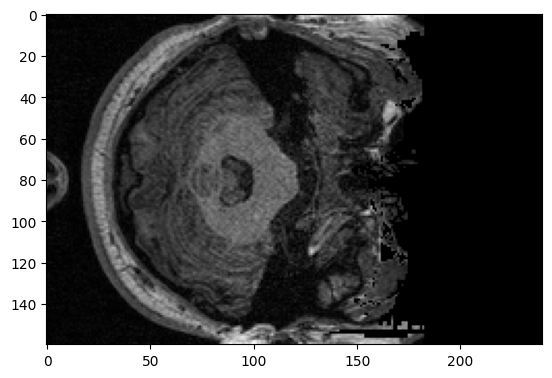

In [58]:
# Display the image

plt.imshow(data[:, :, 90], cmap='gray')
plt.axis('on')



## Preprocessing

C:\Users\Gelo\AppData\Local\Temp\ipykernel_21064\4211580262.py:11: UserWarning: Casting data from int16 to float32
  resampled_data = resample_img(data, target_affine=np.diag(target_voxel_dimensions))
C:\Users\Gelo\AppData\Local\Temp\ipykernel_21064\4211580262.py:11: UserWarning: Casting data from int16 to float32
  resampled_data = resample_img(data, target_affine=np.diag(target_voxel_dimensions))
C:\Users\Gelo\AppData\Local\Temp\ipykernel_21064\4211580262.py:11: UserWarning: Casting data from int16 to float32
  resampled_data = resample_img(data, target_affine=np.diag(target_voxel_dimensions))
C:\Users\Gelo\AppData\Local\Temp\ipykernel_21064\4211580262.py:11: UserWarning: Casting data from int16 to float32
  resampled_data = resample_img(data, target_affine=np.diag(target_voxel_dimensions))
C:\Users\Gelo\AppData\Local\Temp\ipykernel_21064\4211580262.py:11: UserWarning: Casting data from int16 to float32
  resampled_data = resample_img(data, target_affine=np.diag(target_voxel_dimensio

,participant_id\tgender\tage\thandedness\tverbal_iq\tperformance_iq\tfull4_iq\tqc_rest_1\tqc_anatomical_1
0,26001\tMale\t16.92\tRight\t133\t104\t120\tPass...
1,26002\tMale\t15.68\tRight\t106\t106\t107\tPass...
2,26004\tFemale\t14.99\tRight\t119\t123\t125\tPa...
3,26005\tFemale\t15.16\tRight\t116\t131\t126\tPa...
4,26009\tMale\t16.91\tLeft\t113\t81\t97\tPass\tPass


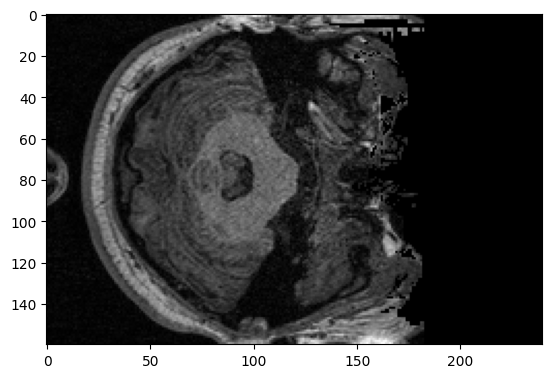

In [63]:
# Resample the dataset

from nilearn.image import resample_img

# Define the target voxel dimensions
target_voxel_dimensions = (1.0, 1.0, 1.0)

# Resample the dataset to the target voxel dimensions
resampled_dataset = []
for data in dataset:
    resampled_data = resample_img(data, target_affine=np.diag(target_voxel_dimensions))
    resampled_dataset.append(resampled_data)

# Display the resampled image
resampled_data = resampled_dataset[22].get_fdata()
plt.imshow(resampled_data[:, :, 90], cmap='gray')
plt.axis('on')

# Load the labels
labels = pd.read_csv('brown/participants.tsv')
labels.head()


## Loading the Pre-Trained ResNet Model

In [64]:
import torch
from torchvision.models.video import r3d_18

# Load the pre-trained model
model = r3d_18(pretrained=True)

# Modify the last layer
num_classes = 2  # replace with the number of classes in your dataset
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# Print the model
model

c:\Users\Gelo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Gelo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [ ]:
# from sklearn.model_selection import train_test_split

# # Split the dataset into training and validation sets
# train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

# # Print the number of images in the training and validation sets
# print('Number of Images in Training Set: ' + str(len(train_dataset)))
# print('Number of Images in Validation Set: ' + str(len(val_dataset)))